# EAS: Colectores

En este notebook se presenta el entrenamiento de un modelo para detectar y segmentar colectores solares, y clasificarlos según el tipo de equipo. En este prototipo se entrenó un modelo con un GeoJSON de anotaciones de colectores, clasificados en 4 tipos, más un adicional "NA" que corresponde a colectores que no tienen un tipo definido (por falta de información):

* Plano (`PL`)
* Plano sin Cubierta (`PS`)
* Plano con Cubierta (`PC`)
* Tubos de Vacío (`TV`)
* N/A (`NA`)

Al shapefile original de anotaciones se le agregó una columna `class`, con esos nombres, para facilitar el uso de las herramientas de generación de máscaras.

## Preparación de datos

Dado que las anotaciones fueron hechas sobre la cobertura urbana, se entrenará un sólo modelo a partir de la ortoimagen urbana. Aprovechando que `ideuy` nos permite descargar sólo las imágenes que necesitamos para el entrenamiento, utilizaremos el mismo GeoJSON de anotaciones para filtrar la grilla urbana y descargar sólo esas hojas.

El archivo vectorial de anotaciones se encuentra en `data/colectores/shp/` y es:

* `colectores_urb_pol.geojson`: Colectores en cobertura urbana

In [1]:
DATA_DIR = "data/colectores"

In [2]:
!ls $DATA_DIR/shp

colectores_urb_pol.geojson


In [3]:
# Instalamos ideuy
!pip install -U ideuy

     |████████████████████████████████| 503 kB 3.4 MB/s eta 0:00:01


In [4]:
# Reproyectamos a epsg:5381 (requerimiento de ideuy_filter)
!ogr2ogr -f GeoJSON -t_srs epsg:5381 /tmp/colectores_urb_pol_5381.geojson $DATA_DIR/shp/colectores_urb_pol.geojson 

Warning 1: Several features with id = 1 have been found. Altering it to be unique. This warning will not be emitted for this layer


In [5]:
# Generamos la grilla filtrada para urbano
!ideuy_filter -t urban \
              -o /tmp/colectores_urb_grilla.geojson \
              -v \
              /tmp/colectores_urb_pol_5381.geojson

In [7]:
# Descargamos las hojas de la imagen urbana
!ideuy_download \
    -t urban \
    -p rgb_8bit \
    -j4 \
    -v \
    -o $DATA_DIR/train/raw_images \
    /tmp/colectores_urb_grilla.geojson

  0%|                                                    | 0/42 [00:00<?, ?it/s][2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_04/02_Ortoimagenes/04_Ciudad_LPS/03_RGB_8bits/K29B2N9_RGB_8_Remesa_04_LPS.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5M3_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5N1_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5P9_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:22] INFO:ideuy.download:Download https

Una vez que haya terminado el proceso, deberíamos tener dentro de `data/colectores/train` un directorio `raw_images` con las imágenes "crudas" de la ortoimagen.

Estructura de directorios:
```
data/colectores/train/
└── raw_images
```

## Preprocesamiento


La generacion de las imagenes y mascaras se realiza vía *meduy_extract_chips*. Esta herramienta se utiliza tanto en la generación del dataset de entrenamiento como en el de predicción. En el primer caso se generan las imagenes y las mascaras, y en el segundo sólo las imagenes.

Primero, reproyectamos el geojson de anotaciones a epsg:5382, el mismo CRS que las imágenes.

In [17]:
!ogr2ogr -f GeoJSON -t_srs epsg:5382 \
    /tmp/colectores_urb_pol_5382.geojson \
    $DATA_DIR/shp/colectores_urb_pol.geojson 

Warning 1: Several features with id = 1 have been found. Altering it to be unique. This warning will not be emitted for this layer


Ahora, ejecutamos `meduy_extract_chips` para generar chips. Decidimos generar chips de tamaño 400px tal como los paneles del modelo urbano, porque son las mismas imágenes y los objetos son de similar tamaño.

Además, al entrenar, generamos chips con solapamiento de 100px (idem paneles urbano) para tener más información a la hora de entrenar, y para asegurarnos que el modelo entrene bien cuando los objetos queden en los bordes de la imagen.

In [ ]:
# Chips para entrenar modelo 1
!meduy_extract_chips \
    $DATA_DIR/train/raw_images/*.jpg \
    $DATA_DIR/train/raw_images/*.jp2 \
    -o $DATA_DIR/train/400_100/ \
    --size 400 \
    --step-size 100 \
    --crs epsg:5382 \
    --labels /tmp/colectores_urb_pol_5382.geojson \
    --classes PL PS PC TV NA \
    --aoi /tmp/colectores_urb_pol_5382.geojson \
    -v

Los argumentos del comando son:

* **El primer argumento** es la ruta a las imágenes. Notar que le pasamos `*.jpg` y `\*.jp2`, esto es porque algunas imágenes de IDE están en formato JPEG2000, no JPG, y su extensión es `.jp2`, pero ambos formatos son válidos.*

* **-o** es la ruta del directorio destino. Recomendamos que dicha ruta sea descriptiva, por ejemplo `data_train/chips/400_100/Remesa08/ ” describe : `data_train` → datos usados para entrenar; `400_100` → `<tamaño de la imagen>_<tamaño del step_size>` (las imágenes son cuadradas); `Remesa08` → Remesa sobre la que vamos a trabajar.

* **--size** tamaño de las imágenes resultantes (las imágenes siempre son cuadradas) 
* **--step-size** paso del proceso. Si *step_size* es igual que el *size* entonces no hay overlap en las imágenes. 

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. Como mencionamos antes, para urbano hacemos 100px y 40px de overlap respectivamente. En la predicción valor puede ser igual al tamaño que la imagen, dado que con eso alcanza para cubrir toda la imagen entera.

* **--crs** le asigna un epsg a la imagen resultado. Para las imágenes del vuelo siempre debe ser `epsg:5382`. Esto es sólo necesario para las imágenes de formato JPG/JPEG2000, dado que no tienen CRS asociado.

* **--label-property** nombre de la columna donde se define cada categoría en el archivo vectorial (sólo se usa en el entrenamiento).

* **--classes** nombres de las clases (como aparecen en el geojson), separados por espacios.

* **--aoi** ruta al archivo vectorial con los polígonos de los paneles. Al definir una región de interes, sólo se procesan las imagenes que interceptan con los paneles. Es decir, no se generarán chips donde no haya paneles.

Este comando va a generar dos carpetas en la ruta de destino : "images" y "masks". Los archivos de la primera van a ser de tipo Tiff de 3 bandas (RGB) y los de la segunda van a ser también de tipo Tiff, pero de N bandas donde N representa el número de clases, en este caso 1, porque solo estamos interesados en segmentar paneles. Esta imagen de una banda es una máscara binaria.

Al terminar el proceso, deberíamos tener esta estructura de directorios:

```
data/colectores/train
├── 400_100
│   ├── images
│   └── masks
└── raw_images
```

## Entrenamiento

Las librerías que importamos nos permite acceder a las herramientas que vamos a utilizar a lo largo del proyecto como por ejemplo la función de train y predict  del modelo de Unet 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

Using TensorFlow backend.


En esta etapa debemos definir la configuración del modelo de ML. A continuación se muestran la mejor configuración encontrada para cada modelo:

In [3]:
config = TrainConfig(width=320,
                     height=320,
                     n_channels=3,
                     n_classes=5,
                     apply_image_augmentation=True,
                     epochs=15,
                     batch_size=32,
                     steps_per_epoch=100,
                     early_stopping_patience=3,
                     validation_split=0.05,
                     images_path=os.path.join(DATA_DIR, 'train', '400_100'),
                     model_path=os.path.join(DATA_DIR, 'weights', 'colectores_m1_v1.h5'),
                     evaluate=False)

Los parámetros son:
* `width`, `height`: Ancho y alto de las imágenes procesadas por la red U-Net. Debe ser múltiplo de 16.
* `n_channels`: Número de canales de la imagen, RGB -> 3
* `n_classes`: Número de clases (**a diferencia de los modelos de paneles, en este caso hay 5 clases**)
* `apply_image_augmentation`: Si es True, amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes, como cambios de brillo, contraste, rotaciones, etc.
* `epochs`: Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento.
* `steps_per_epoch`: Cantidad de pasos por epoch. Típicamente debe ser igual al numero de imágenes / `batch_size`, si es mayor, incrementará el número de imágenes generadas con image augmentation. Notar que si es menor, un epoch no pasa necesariamente por todo el dataset disponible.
* `batch_size`: Cantidad de imágenes que se procesan a la vez dentro de la GPU, depende de la memoria de la GPU disponible, y está también ligado al ancho y alto de las imágenes. Por ejemplo, en un Tesla P100 entran hasta 32 imágenes de 320x320, pero no más. Si las imágenes fueran de 160x160, podrían entrar 64.
* `early_stopping_patience`: A medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones, se corta el proceso porque se entiende que el error ya disminuyó significativamente.
* `validation_split`: Se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento. Al finalizar cada epoch, se evalua sobre el dataset de validación y se calcula la métrica en ese conjunto de imágenes. Típicamente se usa una proporción 0.2 (20%) o 0.1 (10%), pero en este caso usamos el 5% porque hay pocos datos para entrenar.
* `images_path`: La ruta al directorio con los chips (images/ y masks/) para entrenar.
* `model_path`: La ruta donde se guardarán los pesos del mejor modelo entrenado (archivo con extensión `.h5`)

Antes de ponernos a entrenar, podemos visualizar alguna de las imagenes y mascaras de `images_path` con la siguiente función:

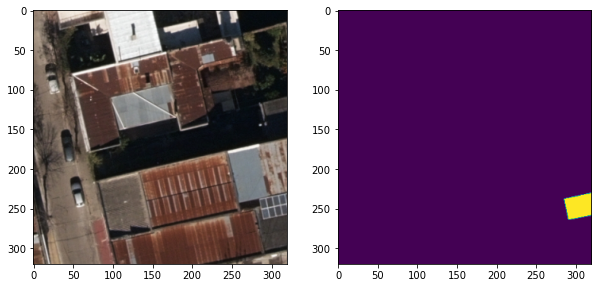

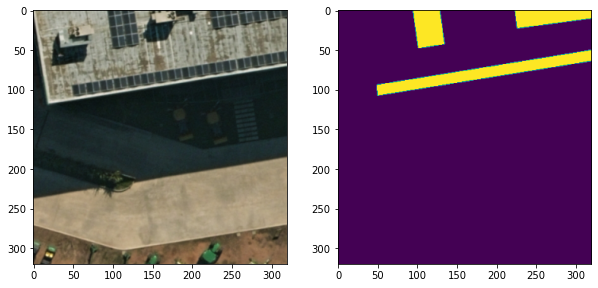

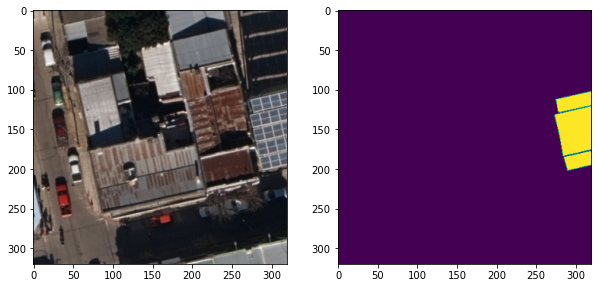

In [6]:
plot_data_generator(train_config=config, num_samples=3, fig_size=(10,10))

Ejecuta el entrenamiento

In [4]:
res = train(config)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_2[0][0]                 

Para cada epoch, se imprimen las siguientes métricas:
* `loss`: *pérdida* o error sobre el dataset de entrenamiento, en este caso es la *binary cross entropy*, muy utilizada para clasificadores. Ver [más información](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a).
* `accuracy`: precisión, proporción de aciertos (TPs y TNs) sobre el total.
* `mean_iou`: promedio de la Intersección sobre Unión (IoU), métrica muy utilizada en problemas de segmentación semántica. También conocido como [índice de Jaccard](https://en.wikipedia.org/wiki/Jaccard_index).

Estas métricas se calculan primero sobre el datset de entrenamiento, y al terminar un epoch, se calculan sobre el dataset de validación (ver valores de las métricas cuyo nombre empieza con `val_`).

Podemos graficar algunas de estas métricas para visualizar mejor como el modelo fue mejorando. Lo importante es ver que el error converge a un valor y el error en validación no es mucho mayor que el de entrenamiento (van a la par). Si fuera mayor, se dice que el modelo sobreajusta (*overfitting*) y nos termina quedando un modelo que predice bien sobre el dataset de entrenamiento pero no sobre nuevos datos.

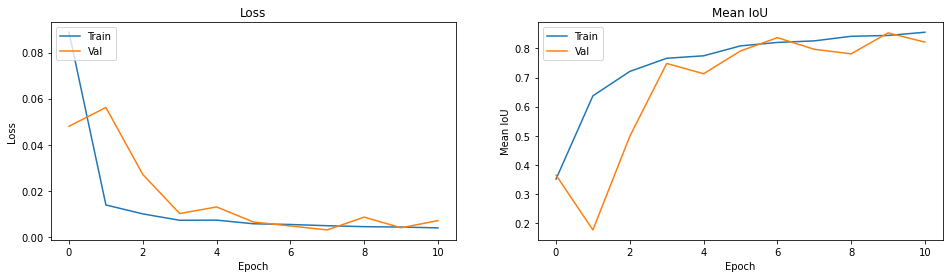

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res.history['mean_iou'])
plt.plot(res.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

Notar que los valores de las métricas en validación fluctuan más que en entrenamiento. Esto en general es así, dado que el datset de validación suele ser mucho más chico que el de entrenamiento, y esto implica que hay menos estadística.

**TODO Matriz de confusión? Agregar como conclusion que hay que agregar más anotaciones por clase (debe ser mas o menos equitativo en lo posible y del orden de los 300 por clase)**